In [1]:
from google.colab import files
uploaded = files.upload()

Saving dataset.zip to dataset.zip


In [2]:
import zipfile

with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

In [3]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: afreenasif07 (afreenasif07-brindavan-college) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
wandb.init(project="polygon-coloring-unet", name="unet-color-by-name", config={
    "epochs": 50,
    "batch_size": 8,
    "learning_rate": 0.001,
    "architecture": "UNet",
    "optimizer": "Adam",
    "loss_function": "MSELoss"
})

In [6]:
import os
print(os.listdir('dataset/dataset/training/inputs'))
print(os.listdir('dataset/dataset/training/outputs'))
print(os.listdir('dataset/dataset/validation/inputs'))

['triangle.png', 'pentagon.png', 'octagon.png', 'star.png', 'circle.png', 'diamond.png', 'square.png', 'hexagon.png']
['magenta_pentagon.png', 'green_diamond.png', 'green_circle.png', 'green_octagon.png', 'magenta_diamond.png', 'red_octagon.png', 'cyan_octagon.png', 'yellow_pentagon.png', 'cyan_hexagon.png', 'magenta_circle.png', 'yellow_diamond.png', 'blue_square.png', 'purple_pentagon.png', 'blue_pentagon.png', 'cyan_star.png', 'yellow_hexagon.png', 'blue_circle.png', 'red_hexagon.png', 'magenta_triangle.png', 'purple_octagon.png', 'blue_octagon.png', 'blue_hexagon.png', 'orange_triangle.png', 'orange_square.png', 'yellow_triangle.png', 'orange_hexagon.png', 'magenta_octagon.png', 'yellow_circle.png', 'magenta_square.png', 'cyan_circle.png', 'orange_octagon.png', 'purple_hexagon.png', 'purple_triangle.png', 'green_star.png', 'green_square.png', 'red_triangle.png', 'green_hexagon.png', 'orange_circle.png', 'blue_triangle.png', 'orange_pentagon.png', 'blue_diamond.png', 'magenta_hexago

In [7]:
import json
with open('dataset/dataset/training/data.json') as f:
    train_data = json.load(f)
    print(train_data[0].keys())
    print(train_data[0])
with open('dataset/dataset/validation/data.json') as f:
    val_data = json.load(f)

dict_keys(['input_polygon', 'colour', 'output_image'])
{'input_polygon': 'octagon.png', 'colour': 'cyan', 'output_image': 'cyan_octagon.png'}


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import webcolors
import matplotlib.pyplot as plt

In [9]:
def color_name_to_hex(color_name):
    try:
        return webcolors.name_to_hex(color_name.strip().lower())
    except ValueError:
        print(f"Unknown color: {color_name}")
        return '#000000'

In [10]:
class PolygonDataset(Dataset):
    def __init__(self, data, root_dir, transform=None):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        d = self.data[idx]
        x_img = Image.open(os.path.join(self.root_dir, 'inputs', d['input_polygon'])).convert('L')
        y_img = Image.open(os.path.join(self.root_dir, 'outputs', d['output_image'])).convert('RGB')

        color_hex = color_name_to_hex(d['colour'])
        rgb = webcolors.hex_to_rgb(color_hex)
        color_tensor = torch.tensor([rgb.red / 255.0, rgb.green / 255.0, rgb.blue / 255.0], dtype=torch.float32)

        if self.transform:
            x_img = self.transform(x_img)
            y_img = self.transform(y_img)

        return x_img, color_tensor, y_img, color_hex

transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
])

train_dataset = PolygonDataset(train_data, 'dataset/dataset/training', transform=transform)
val_dataset = PolygonDataset(val_data, 'dataset/dataset/validation', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [11]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=3):
        super().__init__()
        self.down1 = DoubleConv(in_channels, 128)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(128, 256)
        self.pool2 = nn.MaxPool2d(2)
        self.bottom = DoubleConv(256, 512)
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv1 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv2 = DoubleConv(256, 128)
        self.outc = nn.Conv2d(128, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(self.pool1(x1))
        x3 = self.bottom(self.pool2(x2))
        x = self.up1(x3)
        x = torch.cat([x, x2], dim=1)
        x = self.upconv1(x)
        x = self.up2(x)
        x = torch.cat([x, x1], dim=1)
        x = self.upconv2(x)
        return torch.sigmoid(self.outc(x))

def prepare_batch(img, color, device):
    B, _, H, W = img.shape
    color_map = color[:, :, None, None].repeat(1, 1, H, W)
    return torch.cat([img, color_map], dim=1).to(device)

In [32]:
for epoch in range(50):
    model.train()
    running_loss = 0
    for imgs, colors, targets, color_hexes in train_loader:
        imgs, colors, targets = imgs.to(device), colors.to(device), targets.to(device)
        inp = prepare_batch(imgs, colors, device)
        pred = model(inp)
        loss = criterion(pred, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        wandb.log({"train_loss": loss.item(), "epoch": epoch})
    if (epoch + 1) % 1 == 0:
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1} Loss: {running_loss/len(train_loader):.4f}")
        wandb.log({"epoch": epoch + 1, "avg_train_loss": avg_loss})

Epoch 1 Loss: 0.0116
Epoch 2 Loss: 0.0114
Epoch 3 Loss: 0.0117
Epoch 4 Loss: 0.0119
Epoch 5 Loss: 0.0120
Epoch 6 Loss: 0.0117
Epoch 7 Loss: 0.0122
Epoch 8 Loss: 0.0119
Epoch 9 Loss: 0.0118
Epoch 10 Loss: 0.0138
Epoch 11 Loss: 0.0119
Epoch 12 Loss: 0.0127
Epoch 13 Loss: 0.0115
Epoch 14 Loss: 0.0111
Epoch 15 Loss: 0.0113
Epoch 16 Loss: 0.0107
Epoch 17 Loss: 0.0110
Epoch 18 Loss: 0.0132
Epoch 19 Loss: 0.0140
Epoch 20 Loss: 0.0144
Epoch 21 Loss: 0.0119
Epoch 22 Loss: 0.0108
Epoch 23 Loss: 0.0113
Epoch 24 Loss: 0.0122
Epoch 25 Loss: 0.0113
Epoch 26 Loss: 0.0119
Epoch 27 Loss: 0.0107
Epoch 28 Loss: 0.0112
Epoch 29 Loss: 0.0111
Epoch 30 Loss: 0.0120
Epoch 31 Loss: 0.0115
Epoch 32 Loss: 0.0153
Epoch 33 Loss: 0.0113
Epoch 34 Loss: 0.0153
Epoch 35 Loss: 0.0139
Epoch 36 Loss: 0.0178
Epoch 37 Loss: 0.0160
Epoch 38 Loss: 0.0169
Epoch 39 Loss: 0.0148
Epoch 40 Loss: 0.0135
Epoch 41 Loss: 0.0129
Epoch 42 Loss: 0.0113
Epoch 43 Loss: 0.0113
Epoch 44 Loss: 0.0119
Epoch 45 Loss: 0.0117
Epoch 46 Loss: 0.01

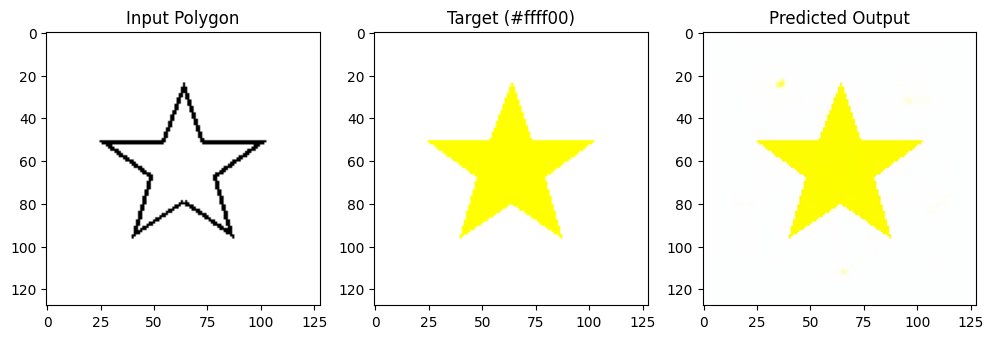

In [33]:
model.eval()
with torch.no_grad():
    for x_img, color_tensor, y_img, color_hex in val_loader:
        x_img = x_img.to(device)
        y_img = y_img.to(device)
        color_tensor = color_tensor.to(device)

        inputs = prepare_batch(x_img, color_tensor, device)
        preds = model(inputs)

        pred_img = preds[0].permute(1, 2, 0).cpu().numpy()
        input_img = x_img[0].squeeze().cpu().numpy()
        target_img = y_img[0].permute(1, 2, 0).cpu().numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(input_img, cmap='gray')
        plt.title('Input Polygon')
        plt.subplot(1, 3, 2)
        plt.imshow(target_img)
        plt.title(f'Target ({color_hex[0]})')
        plt.subplot(1, 3, 3)
        plt.imshow(pred_img)
        plt.title('Predicted Output')
        plt.show()
        break

In [34]:
def inference(model, polygon_path, color_name, transform, device):
    model.eval()
    with torch.no_grad():
        img = Image.open(polygon_path).convert('L')
        img = transform(img).unsqueeze(0).to(device)

        rgb = webcolors.hex_to_rgb(color_name_to_hex(color_name))
        color_tensor = torch.tensor([[rgb.red / 255.0, rgb.green / 255.0, rgb.blue / 255.0]], dtype=torch.float32).to(device)

        input_tensor = prepare_batch(img, color_tensor, device)
        output = model(input_tensor)

        pred_img = output[0].permute(1, 2, 0).cpu().numpy()
        return pred_img

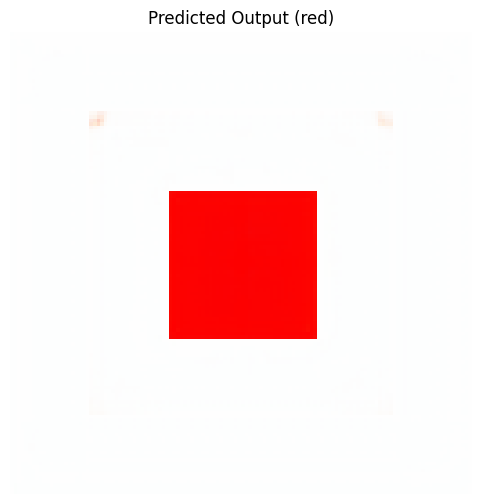

In [35]:
example_polygon_path = 'dataset/dataset/validation/inputs/square.png'

example_color = 'red'

predicted_colored_image = inference(model, example_polygon_path, example_color, transform, device)

plt.figure(figsize=(6, 6))
plt.imshow(predicted_colored_image)
plt.title(f'Predicted Output ({example_color})')
plt.axis('off')
plt.show()

In [36]:
torch.save(model.state_dict(), 'colored_polygon_unet.pth')